In [168]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn import metrics
import shap
import seaborn as sns
import matplotlib.pyplot as plt

In [119]:
df = pd.read_csv('../data/processed/results_concat.csv')

/opt/homebrew/Caskroom/miniconda/base/envs/ravelin36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (26,58,59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [120]:
[c for c in df.columns if 'point' in c]

['total_points']

In [272]:
gameweek_df, player_df = load_data(SEASONS)

In [273]:
def add_moving_average(df, ma_columns, name_col,pref='ma4_', half_life=4):
    df = df.sort_values(by=[name_col, "season", "gw"]).reset_index(drop=True)
    ma_columns_output = ["ma4_" + c for c in ma_columns]
    df[ma_columns_output] = df.groupby(name_col)[ma_columns].apply(
        lambda x: x.ewm(halflife=half_life).mean()
    ).reset_index(drop=True)
    df[ma_columns_output] = df.groupby(name_col)[ma_columns_output].shift(1)
    return df

In [274]:
MA_COLS = [
    'assists', 'attempted_passes', 'big_chances_created',
       'big_chances_missed', 'bonus', 'bps', 'clean_sheets',
       'clearances_blocks_interceptions', 'completed_passes', 'creativity',
       'dribbles', 'ea_index', 'errors_leading_to_goal',
       'errors_leading_to_goal_attempt', 'fouls', 'goals_conceded',
       'goals_scored', 'influence', 'key_passes',
        'loaned_in', 'loaned_out',
       'minutes', 'offside', 'open_play_crosses', 'opponent_team', 'own_goals',
       'penalties_conceded', 'penalties_missed', 'penalties_saved',
       'recoveries', 'red_cards', 'saves', 'selected', 'tackled',
       'tackles', 'target_missed', 'team_a_score', 'team_h_score', 'threat',
        'transfers_balance', 'transfers_in', 'transfers_out',
       'value', 'was_home', 'winning_goals', 'yellow_cards','total_points',
    'ict_index'
            ]

In [275]:
EXCLUDE_COLS = ['name','element','id',
               'id', 'kickoff_time',
       'kickoff_time_formatted', 'round','fixture'] + MA_COLS

In [276]:
gameweek_df.total_points =pd.to_numeric(gameweek_df.total_points)

In [277]:
cat_cols = gameweek_df.select_dtypes('O').columns
gameweek_df[cat_cols] = gameweek_df[cat_cols].astype('category')

In [310]:
with_ma = add_moving_average(gameweek_df, MA_COLS,'name', half_life=1)

In [311]:
train = with_ma[with_ma.season != '2021-22']
test = with_ma[with_ma.season == '2021-22']

In [312]:
X_train, X_test = train.drop(columns = EXCLUDE_COLS), test.drop(columns=EXCLUDE_COLS)
y_train, y_test = train.total_points, test.total_points                 

In [313]:
reg = lgb.LGBMRegressor()

In [314]:
reg.fit(X_train,y_train)

LGBMRegressor()

In [315]:
y_pred = reg.predict(X_test)

In [316]:
y_dummy = np.repeat(y_train.mean(), len(X_test))

In [317]:
metrics.mean_squared_error(y_pred,y_test)

2.6464314030607334

In [318]:
metrics.mean_squared_error(y_dummy,y_test)

6.220461039973227

In [319]:
explainer = shap.TreeExplainer(reg)

In [320]:
shap_values = explainer.shap_values(X_train)
# rank features by importance - average abs. shap value
importance_shap = np.abs(shap_values).mean(axis=0)

In [321]:
ranked_features = sorted(
    list(zip(X_train.columns, importance_shap)), key=lambda x: -x[1]
)  # sorted by importance (descending)

In [322]:
features_df = pd.DataFrame(ranked_features, columns=["feature", "importance"])


In [323]:
features_df["% total importance"] = (
    features_df.importance / features_df.importance.sum()
) * 100

Text(0.5, 1.0, 'Top 20 features \n % Average abs. Shap value importance (% total)')

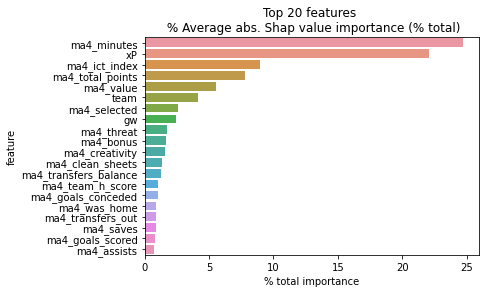

In [324]:
ax = sns.barplot(data=features_df.head(20), y="feature", x="% total importance")
plt.title("Top 20 features \n % Average abs. Shap value importance (% total)")

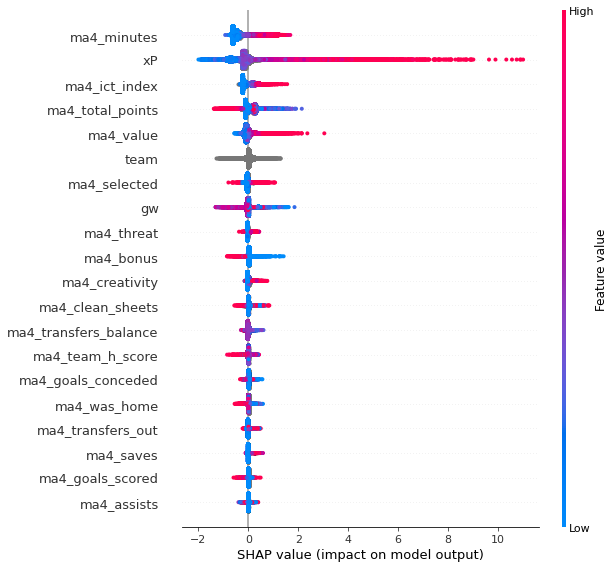

In [327]:

ax = shap.summary_plot(
    shap_values,
    X_train,
)
plt.show()


In [331]:
X_plot = X_train.copy()
for col in X_train.select_dtypes("category").columns:
    X_plot[col] = X_train[col].cat.codes

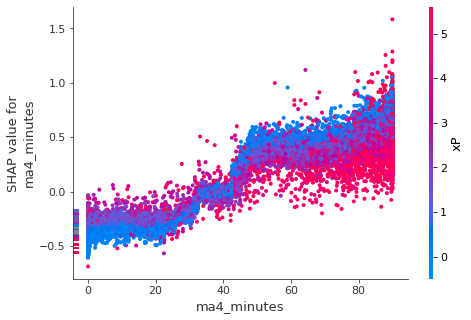

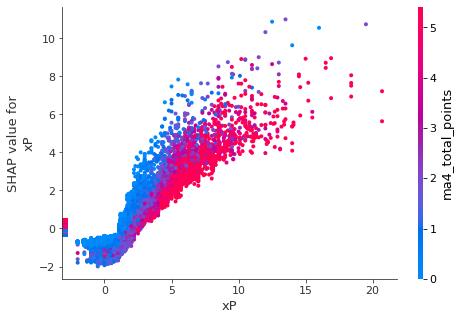

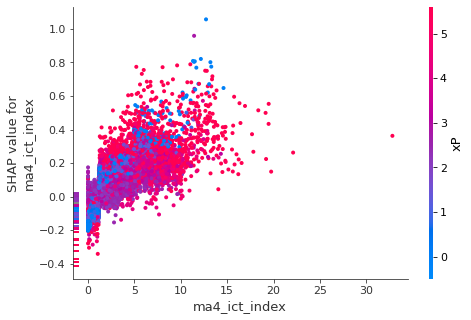

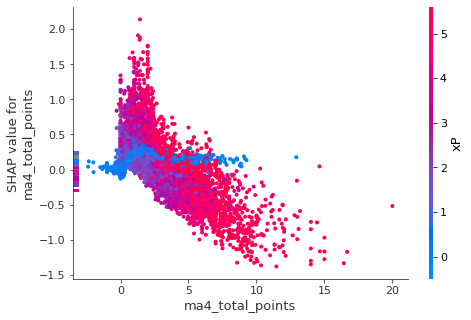

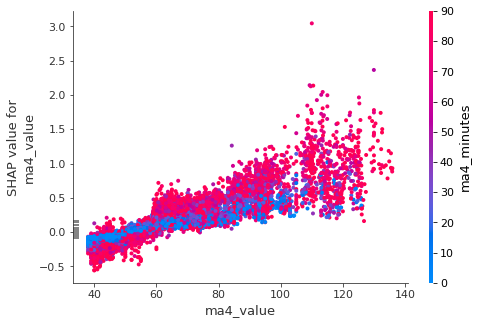

Passing the fontdict parameter of _set_ticklabels() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


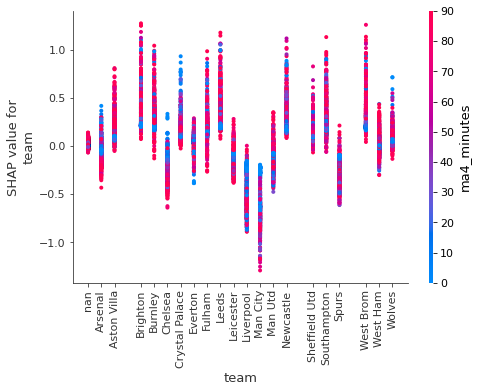

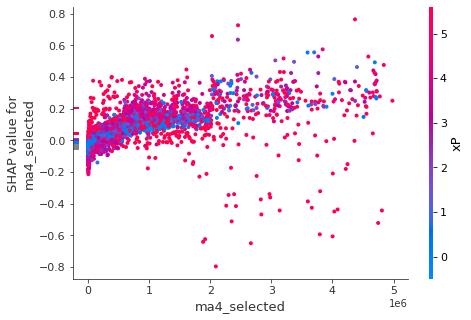

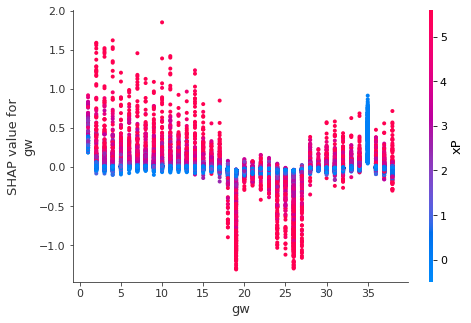

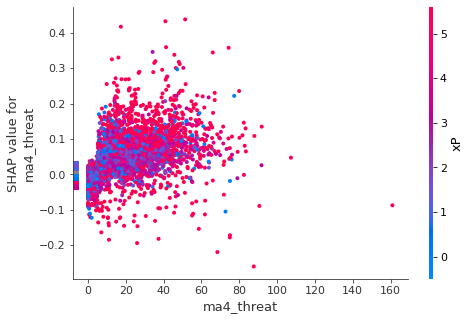

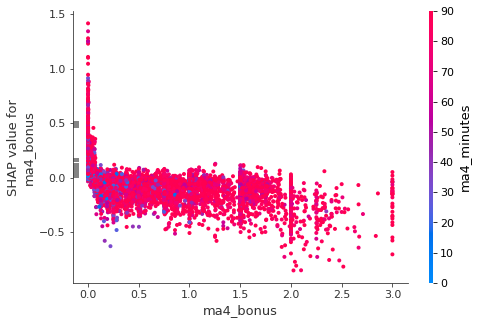

In [337]:
for feat in ranked_features[:10]:
    ax = shap.dependence_plot(
        ind=feat[0],
        shap_values=shap_values,
        features=X_plot,
        display_features=X_train,
    
    )
    plt.show()